
# Evaluation Code

This notebook is designed to evaluate prediction results and compare them against reference evaluation data. The approach implemented here is custom-built for this specific workflow.

For a more standardized and widely adopted benchmarking method, consider using Google’s WeatherBench 2, which provides tools and datasets for evaluating weather prediction models in a consistent and reproducible way.

Weather bench : https://github.com/google-research/weatherbench2 


In [25]:
# Standard library imports
import dataclasses
import datetime
import glob
import math
import os
import warnings
import zipfile
from typing import Optional

# Third-party numerical/scientific computing
import cartopy.crs as ccrs
import haiku as hk
import jax
import numpy as np
import pandas as pd
import xarray as xr

# Visualization
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt

from matplotlib.dates import DateFormatter

# IPython and interactive widgets
from IPython import display
from IPython.display import HTML, display
import ipywidgets as widgets

# Cloud and data services
import seaborn as sns
import cdsapi

# GraphCast specific modules
from graphcast import (
    checkpoint,
    data_utils,
    denoiser,
    gencast,
    nan_cleaning,
    normalization,
    rollout,
    xarray_jax,
    xarray_tree
)

# Suppress warnings
warnings.filterwarnings("ignore")

In [26]:

# replace the result you want to test
evaluation_data = xr.open_dataset("evaluation_data/evaluations_concat.nc")
prediction = xr.open_dataset("evaluation_data/zgeg.nc")



In [27]:
prediction

<xarray.Dataset>
Dimensions:                   (batch: 1, time: 12, lat: 181, lon: 360, level: 13)
Coordinates:
  * lon                       (lon) float32 0.0 1.0 2.0 ... 357.0 358.0 359.0
  * lat                       (lat) float32 -90.0 -89.0 -88.0 ... 88.0 89.0 90.0
  * level                     (level) int64 50 100 150 200 ... 700 850 925 1000
  * time                      (time) timedelta64[ns] 12:00:00 ... 23:00:00
    datetime                  (time) datetime64[ns] ...
Dimensions without coordinates: batch
Data variables:
    10m_u_component_of_wind   (batch, time, lat, lon) float64 ...
    10m_v_component_of_wind   (batch, time, lat, lon) float64 ...
    2m_temperature            (batch, time, lat, lon) float64 ...
    geopotential              (batch, time, level, lat, lon) float64 ...
    mean_sea_level_pressure   (batch, time, lat, lon) float64 ...
    sea_surface_temperature   (batch, time, lat, lon) float64 ...
    specific_humidity         (batch, time, level, lat, lon) float64 ...
    temperature               (batch, time, level, lat, lon) float64 ...
    total_precipitation_12hr  (batch, time, lat, lon) float64 ...
    u_component_of_wind       (batch, time, level, lat, lon) float64 ...
    v_component_of_wind       (batch, time, level, lat, lon) float64 ...
    vertical_velocity         (batch, time, level, lat, lon) float64 ...

In [28]:
evaluation_data

<xarray.Dataset>
Dimensions:                  (batch: 1, time: 72, level: 13, lat: 181, lon: 360)
Coordinates:
  * time                     (time) timedelta64[ns] -1 days +12:00:00 ... 11:...
  * level                    (level) int32 50 100 150 200 ... 700 850 925 1000
  * lat                      (lat) float32 -90.0 -89.0 -88.0 ... 88.0 89.0 90.0
  * lon                      (lon) float32 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
    datetime                 (batch, time) datetime64[ns] ...
Dimensions without coordinates: batch
Data variables: (12/17)
    geopotential             (batch, time, level, lat, lon) float32 ...
    specific_humidity        (batch, time, level, lat, lon) float32 ...
    temperature              (batch, time, level, lat, lon) float32 ...
    u_component_of_wind      (batch, time, level, lat, lon) float32 ...
    v_component_of_wind      (batch, time, level, lat, lon) float32 ...
    vertical_velocity        (batch, time, level, lat, lon) float32 ...
    ...                       ...
    sea_surface_temperature  (batch, time, lat, lon) float32 ...
    day_progress_cos         (batch, time, lon) float32 ...
    day_progress_sin         (batch, time, lon) float32 ...
    year_progress_cos        (batch, time) float32 ...
    year_progress_sin        (batch, time) float32 ...
    geopotential_at_surface  (time, lat, lon) float32 ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-04-23T15:15 GRIB to CDM+CF via cfgrib-0.9.1...

In [29]:
for dt in evaluation_data["datetime"].values:
    print(str(dt))

print("\n")

for dt in prediction["datetime"].values:
    print(str(dt))



['2019-03-30T00:00:00.000000000' '2019-03-30T01:00:00.000000000'
 '2019-03-30T02:00:00.000000000' '2019-03-30T03:00:00.000000000'
 '2019-03-30T04:00:00.000000000' '2019-03-30T05:00:00.000000000'
 '2019-03-30T06:00:00.000000000' '2019-03-30T07:00:00.000000000'
 '2019-03-30T08:00:00.000000000' '2019-03-30T09:00:00.000000000'
 '2019-03-30T10:00:00.000000000' '2019-03-30T11:00:00.000000000'
 '2019-03-30T12:00:00.000000000' '2019-03-30T13:00:00.000000000'
 '2019-03-30T14:00:00.000000000' '2019-03-30T15:00:00.000000000'
 '2019-03-30T16:00:00.000000000' '2019-03-30T17:00:00.000000000'
 '2019-03-30T18:00:00.000000000' '2019-03-30T19:00:00.000000000'
 '2019-03-30T20:00:00.000000000' '2019-03-30T21:00:00.000000000'
 '2019-03-30T22:00:00.000000000' '2019-03-30T23:00:00.000000000'
 '2019-03-31T00:00:00.000000000' '2019-03-31T01:00:00.000000000'
 '2019-03-31T02:00:00.000000000' '2019-03-31T03:00:00.000000000'
 '2019-03-31T04:00:00.000000000' '2019-03-31T05:00:00.000000000'
 '2019-03-31T06:00:00.000

In [30]:

# Force loading data into memory
predictions_concat_loaded = prediction.compute()
evaluation_data_loaded = evaluation_data.compute()
# Remove the batch dimension if it's always 1
evaluation_data_loaded = evaluation_data_loaded.isel(batch=0)

# Now datetime should be 1D and match time
evaluation_data_loaded = evaluation_data_loaded.set_index(time='datetime')

# Remove the batch dimension if it's always 1
predictions_concat_loaded = predictions_concat_loaded.isel(batch=0)
# Now datetime should be 1D and match time
predictions_concat_loaded = predictions_concat_loaded.set_index(time='datetime')

# Perform the selection
eval_times = predictions_concat_loaded.time.values
matched_evaluations = evaluation_data_loaded.sel(time=eval_times, method="nearest")



In [32]:
predictions_concat_loaded

<xarray.Dataset>
Dimensions:                   (time: 12, lat: 181, lon: 360, level: 13)
Coordinates:
  * lon                       (lon) float32 0.0 1.0 2.0 ... 357.0 358.0 359.0
  * lat                       (lat) float32 -90.0 -89.0 -88.0 ... 88.0 89.0 90.0
  * level                     (level) int64 50 100 150 200 ... 700 850 925 1000
  * time                      (time) datetime64[ns] 2019-03-30 ... 2019-04-04...
Data variables:
    10m_u_component_of_wind   (time, lat, lon) float64 0.4319 0.4468 ... -0.3266
    10m_v_component_of_wind   (time, lat, lon) float64 0.04277 ... -0.2401
    2m_temperature            (time, lat, lon) float64 227.5 227.5 ... 244.5
    geopotential              (time, level, lat, lon) float64 1.935e+05 ... 5...
    mean_sea_level_pressure   (time, lat, lon) float64 1.005e+05 ... 1.007e+05
    sea_surface_temperature   (time, lat, lon) float64 nan nan nan ... nan nan
    specific_humidity         (time, level, lat, lon) float64 2.848e-06 ... 0...
    temperature               (time, level, lat, lon) float64 215.4 ... 245.0
    total_precipitation_12hr  (time, lat, lon) float64 0.0001313 ... 1.388e-05
    u_component_of_wind       (time, level, lat, lon) float64 0.8208 ... -0.3661
    v_component_of_wind       (time, level, lat, lon) float64 0.1022 ... -0.1071
    vertical_velocity         (time, level, lat, lon) float64 0.001425 ... 0....

In [33]:
evaluation_data_loaded

<xarray.Dataset>
Dimensions:                  (time: 72, level: 13, lat: 181, lon: 360)
Coordinates:
  * time                     (time) datetime64[ns] 2019-03-30 ... 2019-04-01T...
  * level                    (level) int32 50 100 150 200 ... 700 850 925 1000
  * lat                      (lat) float32 -90.0 -89.0 -88.0 ... 88.0 89.0 90.0
  * lon                      (lon) float32 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
Data variables: (12/17)
    geopotential             (time, level, lat, lon) float32 1.935e+05 ... 793.8
    specific_humidity        (time, level, lat, lon) float32 2.847e-06 ... 0....
    temperature              (time, level, lat, lon) float32 215.7 ... 259.2
    u_component_of_wind      (time, level, lat, lon) float32 -0.0002594 ... 0...
    v_component_of_wind      (time, level, lat, lon) float32 0.0003052 ... 3....
    vertical_velocity        (time, level, lat, lon) float32 0.009427 ... -0....
    ...                       ...
    sea_surface_temperature  (time, lat, lon) float32 nan nan ... 271.5 271.5
    day_progress_cos         (time, lon) float32 1.0 1.0 1.0 ... 0.9659 0.9659
    day_progress_sin         (time, lon) float32 0.0 0.0 0.0 ... -0.2588 -0.2588
    year_progress_cos        (time) float32 -0.9949 -0.995 ... -0.9999 -0.9999
    year_progress_sin        (time) float32 0.1009 0.1002 ... 0.01648 0.01577
    geopotential_at_surface  (time, lat, lon) float32 -266.7 -266.7 ... 992.4
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-04-23T15:15 GRIB to CDM+CF via cfgrib-0.9.1...

In [34]:
# Extract common variables
common_vars = list(set(predictions_concat_loaded.data_vars) & set(matched_evaluations.data_vars))
matched_evaluations = matched_evaluations[common_vars]
predictions_data_subset = predictions_concat_loaded[common_vars]

# Unify dimension order (e.g., time, lat, lon)
matched_evaluations = matched_evaluations.transpose("time", "lat", "lon", ...)
predictions_data_subset = predictions_data_subset.transpose("time", "lat", "lon", ...)

In [35]:
def check_duplicate_times(ds):
    time_values = ds['time'].values
    return len(time_values) != len(np.unique(time_values))

print("Duplicates in predictions_data_subset:", check_duplicate_times(predictions_data_subset))
print("Duplicates in matched_evaluations:", check_duplicate_times(matched_evaluations))

def remove_duplicate_times(ds):
    _, index = np.unique(ds['time'], return_index=True)
    return ds.isel(time=index)

# Apply to both datasets
predictions_data_subset = remove_duplicate_times(predictions_data_subset)
matched_evaluations = remove_duplicate_times(matched_evaluations)



Duplicates in predictions_data_subset: False
Duplicates in matched_evaluations: True


In [36]:
def safe_calculate_metrics(pred, true):
    metrics = {}
    for var in pred.data_vars:
        try:
            var_pred = pred[var]
            var_true = true[var]
            # RMSE
            rmse = np.sqrt(((var_pred - var_true)**2).mean(dim=["lat", "lon"]))
            # MAE
            mae = np.abs(var_pred - var_true).mean(dim=["lat", "lon"])
            # Calculate correlation coefficient
            corr = xr.corr(var_pred, var_true, dim=["lat", "lon"])
            # r2
            r2 = 1 - ((var_pred - var_true)**2).mean(dim=["lat", "lon"]) / ((var_true - var_true.mean(dim=["lat", "lon"]))**2).mean(dim=["lat", "lon"])
            metrics[var] = xr.Dataset({"rmse": rmse, "mae": mae, "correlation": corr, "r2":r2})
        except Exception as e:
            print(f"An error occurred while calculating variable {var}: {str(e)}")
            metrics[var] = None
    return metrics


var_metrics = safe_calculate_metrics(predictions_data_subset, matched_evaluations)

In [37]:
var_metrics

{'u_component_of_wind': <xarray.Dataset>
 Dimensions:      (level: 13, time: 6)
 Coordinates:
   * level        (level) int64 50 100 150 200 250 300 ... 600 700 850 925 1000
   * time         (time) datetime64[ns] 2019-03-30 ... 2019-04-01T12:00:00
 Data variables:
     rmse         (time, level) float64 1.577 1.433 1.536 ... 7.461 7.656 5.979
     mae          (time, level) float64 1.167 1.077 1.115 ... 5.276 5.332 4.147
     correlation  (time, level) float64 0.9867 0.991 0.9944 ... 0.533 0.5213
     r2           (time, level) float64 0.9736 0.9819 0.9887 ... 0.0458 0.02925,
 'sea_surface_temperature': <xarray.Dataset>
 Dimensions:      (time: 6)
 Coordinates:
   * time         (time) datetime64[ns] 2019-03-30 ... 2019-04-01T12:00:00
 Data variables:
     rmse         (time) float64 nan nan nan nan nan nan
     mae          (time) float64 nan nan nan nan nan nan
     correlation  (time) float64 nan nan nan nan nan nan
     r2           (time) float64 nan nan nan nan nan nan,
 '2m_tem

In [38]:
from IPython.display import display

metrics_list = []

for var, ds in var_metrics.items():
    if ds is not None:
        try:
            # Skip datasets with no dimensions
            if ds.dims and len(ds.dims) > 0:
                df = ds.to_dataframe().reset_index()
                df["variable"] = var
                metrics_list.append(df)
            else:
                print(f"Skipping variable {var} because it has no dimensions.")
        except Exception as e:
            print(f"Skipping variable {var} due to error: {str(e)}")


metrics_df = pd.concat(metrics_list)

# Calculate the average
summary_table = metrics_df.groupby(["variable", "time"]).agg({
    "rmse": "mean",
    "mae": "mean",
    "correlation": "mean",
    "r2": "mean"
}).reset_index()

# Hightlight best value
def highlight_min_max(s):
    is_rmse_mae = s.name in ["rmse", "mae"]
    is_corr = s.name == "correlation"
    is_r2 = s.name == "r2"
    styles = []
    for val in s:
        if is_rmse_mae:
            # style = 'background-color: lightgreen' if val > s.median() else ''
            style = ''
        elif is_corr:
            style = 'background-color: lightgreen' if val > 0.8 else ''
        elif is_r2:
            style = 'background-color: lightgreen' if val > 0.8 else ''
        else:
            style = ''
        styles.append(style)
    return styles

styled_table = (
    summary_table.style
    .format({"rmse": "{:.2f}", "mae": "{:.2f}", "correlation": "{:.2f}", "r2":"{:.2f}"})
    .apply(highlight_min_max, subset=["rmse", "mae", "correlation", "r2"])
    .set_caption("Global Prodiction Precise")
)

display(styled_table)

,variable,time,rmse,mae,correlation,r2
0,10m_u_component_of_wind,2019-03-30 00:00:00,0.72,0.51,0.99,0.98
1,10m_u_component_of_wind,2019-03-30 12:00:00,3.28,2.11,0.82,0.64
2,10m_u_component_of_wind,2019-03-31 00:00:00,4.14,2.68,0.72,0.44
3,10m_u_component_of_wind,2019-03-31 12:00:00,4.80,3.29,0.63,0.24
4,10m_u_component_of_wind,2019-04-01 00:00:00,5.14,3.54,0.57,0.10
5,10m_u_component_of_wind,2019-04-01 12:00:00,5.38,3.75,0.52,0.03
6,10m_v_component_of_wind,2019-03-30 00:00:00,0.74,0.52,0.99,0.98
7,10m_v_component_of_wind,2019-03-30 12:00:00,3.66,2.33,0.71,0.41
8,10m_v_component_of_wind,2019-03-31 00:00:00,4.69,3.07,0.51,-0.03
9,10m_v_component_of_wind,2019-03-31 12:00:00,5.23,3.56,0.39,-0.28


In [39]:
# Calculate average R2 across all variables for each time point
r2_summary = metrics_df.groupby("time").agg({
    "r2": "mean"
}).reset_index()

# Format the table nicely
styled_r2_table = (
    r2_summary.style
    .format({"r2": "{:.3f}"})  # Format R2 to 3 decimal places
    .bar(subset=["r2"], align='mid', color=['#d65f5f', '#5fba7d'])  # Add color bar
    .set_caption("Average R² Across All Variables Over Time")
    .set_properties(**{'text-align': 'center'})
    .hide(axis="index")  # Hide the index column
)

display(styled_r2_table)

time,r2
2019-03-30 00:00:00,0.897
2019-03-30 12:00:00,0.634
2019-03-31 00:00:00,0.489
2019-03-31 12:00:00,0.372
2019-04-01 00:00:00,0.317
2019-04-01 12:00:00,0.290


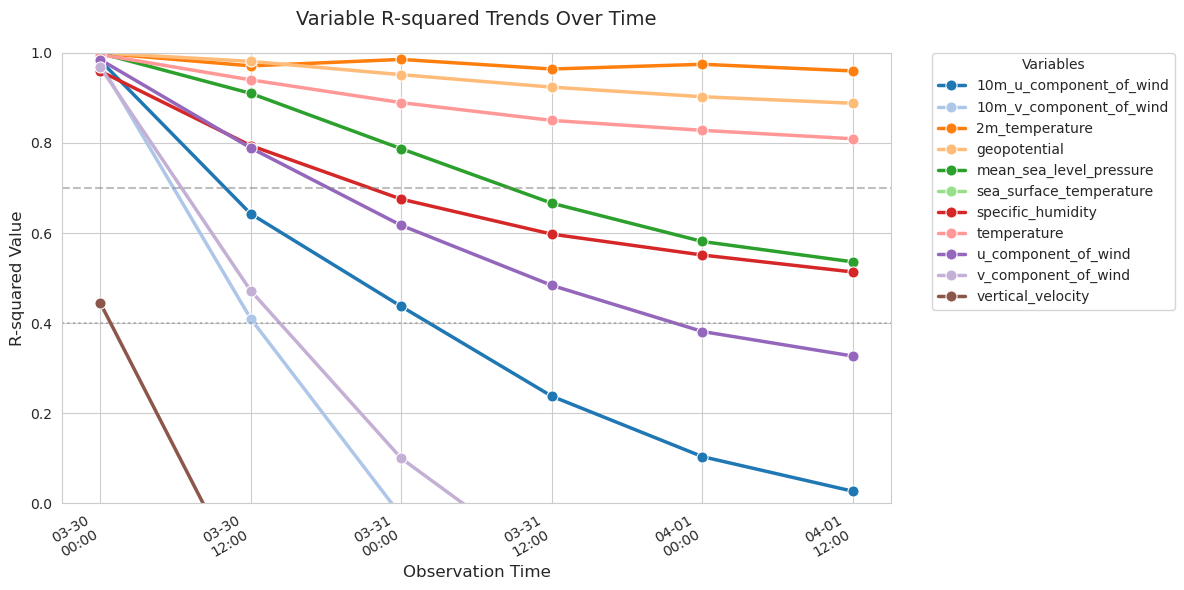

In [40]:
metrics_list = []
for var, ds in var_metrics.items():
    if ds is not None:
        try:
            # Skip datasets with no dimensions
            if ds.dims and len(ds.dims) > 0:
                df = ds.to_dataframe().reset_index()
                df["variable"] = var
                metrics_list.append(df)
            else:
                print(f"Skipping variable {var} because it has no dimensions.")
        except Exception as e:
            print(f"Skipping variable {var} due to error: {str(e)}")

metrics_df = pd.concat(metrics_list)

# Calculate global averages grouped by variable and timestep (keeping only R²)
summary_table = metrics_df.groupby(["variable", "time"]).agg({
    "r2": "mean"  # Key modification: correlation → r2
}).reset_index()

# Set up figure
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Ensure proper datetime format
if not pd.api.types.is_datetime64_any_dtype(summary_table['time']):
    summary_table['time'] = pd.to_datetime(summary_table['time'])

# Get unique timestamps
unique_times = summary_table['time'].unique()
# unique_times.sort()

# Create line plot
ax = sns.lineplot(
    data=summary_table,
    x="time",
    y="r2",  # Changed Y-axis metric
    hue="variable",
    palette="tab20",
    marker="o",
    linewidth=2.5,
    markersize=8
)

# Set x-axis ticks
ax.set_xticks(unique_times)

# Time formatting
date_format = DateFormatter("%Y-%m-%d\n%H:%M") if len(unique_times) <=5 else DateFormatter("%m-%d\n%H:%M")
ax.xaxis.set_major_formatter(date_format)

# Plot annotations optimization 
plt.title("Variable R-squared Trends Over Time", fontsize=14, pad=20)  # Modified title
plt.xlabel("Observation Time", fontsize=12)
plt.ylabel("R-squared Value", fontsize=12)  # Modified Y-axis label
plt.ylim(0, 1)  # R² range maintained [0,1]
plt.legend(
    title="Variables",
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.
)

# Add reference lines (adjusted for typical R² thresholds)
plt.axhline(0.7, color='grey', linestyle='--', alpha=0.5, label='Good Fit')  # Typical R² threshold
plt.axhline(0.4, color='grey', linestyle=':', alpha=0.5, label='Moderate Fit')

plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

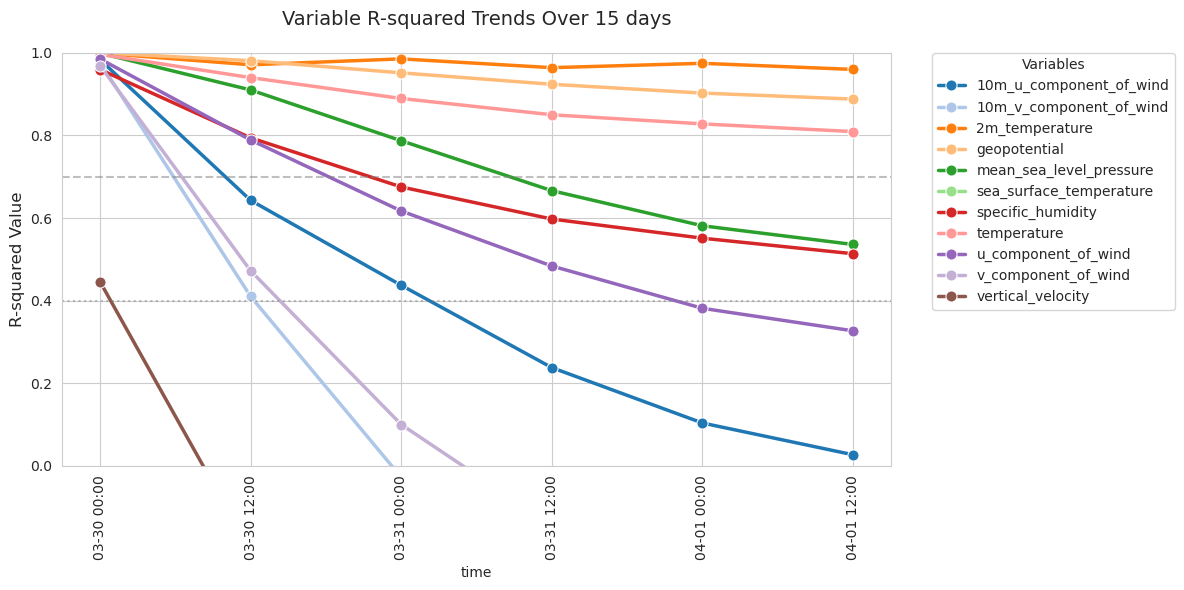

In [41]:
metrics_list = []
for var, ds in var_metrics.items():
    if ds is not None:
        try:
            # Skip datasets with no dimensions
            if ds.dims and len(ds.dims) > 0:
                df = ds.to_dataframe().reset_index()
                df["variable"] = var
                metrics_list.append(df)
            else:
                print(f"Skipping variable {var} because it has no dimensions.")
        except Exception as e:
            print(f"Skipping variable {var} due to error: {str(e)}")

metrics_df = pd.concat(metrics_list)

# Calculate global averages grouped by variable and timestep (keeping only R²)
summary_table = metrics_df.groupby(["variable", "time"]).agg({
    "r2": "mean"  # Key modification: correlation → r2
}).reset_index()

# Set up figure
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Ensure proper datetime format
if not pd.api.types.is_datetime64_any_dtype(summary_table['time']):
    summary_table['time'] = pd.to_datetime(summary_table['time'])

# Get unique timestamps
unique_times = summary_table['time'].unique()
# unique_times.sort()

# Create line plot
ax = sns.lineplot(
    data=summary_table,
    x="time",
    y="r2",  # Changed Y-axis metric
    hue="variable",
    palette="tab20",
    marker="o",
    linewidth=2.5,
    markersize=8
)

# Set x-axis ticks
ax.set_xticks(unique_times)

# Time formatting


# Plot annotations optimization 
plt.title("Variable R-squared Trends Over 15 days", fontsize=14, pad=20)  # Modified title

# Set x-axis ticks to only show 00:00 and 12:00
tick_times = summary_table['time'][summary_table['time'].dt.hour.isin([0, 12])].unique()
ax.set_xticks(tick_times)

# Format the tick labels
date_format = DateFormatter("%m-%d %H:%M")
ax.xaxis.set_major_formatter(date_format)

# ✅ Rotation verticale des dates
ax.tick_params(axis='x', labelrotation=90)



plt.ylabel("R-squared Value", fontsize=12)  # Modified Y-axis label
plt.ylim(0, 1)  # R² range maintained [0,1]
plt.legend(
    title="Variables",
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.
)

# Add reference lines (adjusted for typical R² thresholds)
plt.axhline(0.7, color='grey', linestyle='--', alpha=0.5, label='Good Fit')  # Typical R² threshold
plt.axhline(0.4, color='grey', linestyle=':', alpha=0.5, label='Moderate Fit')

#plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()







